In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dinesh1125","key":"c9d1aeda29657bc24a7b33f3447d488a"}'}

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)

!mv kaggle.json /root/.kaggle/

In [ ]:
!kaggle competitions download -c facial-keypoints-detection

In [ ]:
import zipfile
with zipfile.ZipFile('facial-keypoints-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('facial-keypoints-detection')

In [ ]:
with zipfile.ZipFile('facial-keypoints-detection/training.zip', 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile('facial-keypoints-detection/test.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

import cv2
from math import sin, cos, pi

import tensorflow as tf
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import (
    Input, Dense, Dropout, Activation, Flatten, Conv2D, Convolution2D,
    MaxPooling2D, MaxPool2D, SeparableConv2D, GlobalAveragePooling2D,
    ZeroPadding2D, LeakyReLU, BatchNormalization
)
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils import to_categorical, plot_model
from keras import regularizers, models
from keras.regularizers import l2

In [ ]:
train_path = 'training.csv'
test_path = 'test.csv'
lookid_path = 'facial-keypoints-detection/IdLookupTable.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
lookid_data = pd.read_csv(lookid_path)

In [ ]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


In [ ]:
lookid_data.head().T

,0,1,2,3,4
RowId,1,2,3,4,5
ImageId,1,1,1,1,1
FeatureName,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x
Location,NaN,NaN,NaN,NaN,NaN


In [ ]:
len(train_data), len(test_data)

(7049, 1783)

In [ ]:
train_data.isnull().sum()

,0
left_eye_center_x,10
left_eye_center_y,10
right_eye_center_x,13
right_eye_center_y,13
left_eye_inner_corner_x,4778
left_eye_inner_corner_y,4778
left_eye_outer_corner_x,4782
left_eye_outer_corner_y,4782
right_eye_inner_corner_x,4781
right_eye_inner_corner_y,4781


In [ ]:
train_data_full = train_data.dropna()
print("train_data_full shape: {}".format(np.shape(train_data_full)))

train_data_full shape: (2140, 31)


In [ ]:
train_data = train_data.ffill()

In [ ]:
train_data.isnull().sum()

,0
left_eye_center_x,0
left_eye_center_y,0
right_eye_center_x,0
right_eye_center_y,0
left_eye_inner_corner_x,0
left_eye_inner_corner_y,0
left_eye_outer_corner_x,0
left_eye_outer_corner_y,0
right_eye_inner_corner_x,0
right_eye_inner_corner_y,0


In [ ]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='o', s=30, c='r')
    axis.set_title(title)

In [ ]:
def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop('Image',axis = 1)
    keypoint_features = []
    for idx, sample_keypoints in keypoint_data.iterrows():
        keypoint_features.append(sample_keypoints)
    keypoint_features = np.array(keypoint_features, dtype = 'float')
    return keypoint_features

In [ ]:
train_images = load_images(train_data)
print("Shape of train_images: {}".format(np.shape(train_images)))
train_keypoints = load_keypoints(train_data)
print("Shape of train_keypoints: {}".format(np.shape(train_keypoints)))
test_images = load_images(test_data)
print("Shape of test_images: {}".format(np.shape(test_images)))

Shape of train_images: (7049, 96, 96, 1)
Shape of train_keypoints: (7049, 30)
Shape of test_images: (1783, 96, 96, 1)


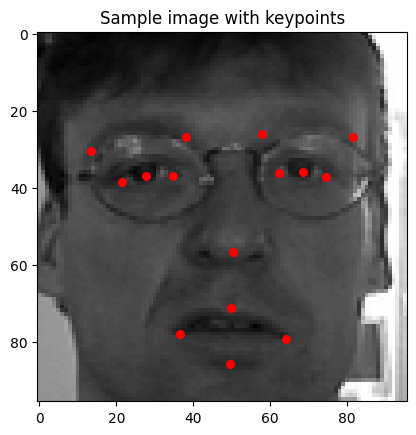

In [ ]:
idx = 15
fig, axis = plt.subplots()
plot_sample(train_images[idx], train_keypoints[idx], axis, "Sample image with keypoints")

# Data Augmentation

In [ ]:
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=2)
    for points in keypoints:
        flipped = [96. - val if i % 2 == 0 else val for i, val in enumerate(points)]
        flipped_keypoints.append(flipped)
    return flipped_images, flipped_keypoints


def rotate_augmentation(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    for base_angle in config.rotation_angles:
        for angle in [base_angle, -base_angle]:
            rotation_matrix = cv2.getRotationMatrix2D((48, 48), angle, 1.0)
            angle_in_radians = -angle * pi / 180.
            for img in images:
                rotated_img = cv2.warpAffine(img, rotation_matrix, (96, 96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_img)
            for points in keypoints:
                translated_points = points - 48.
                for i in range(0, len(translated_points), 2):
                    x = translated_points[i]
                    y = translated_points[i + 1]
                    translated_points[i] = x * cos(angle_in_radians) - y * sin(angle_in_radians)
                    translated_points[i + 1] = x * sin(angle_in_radians) + y * cos(angle_in_radians)
                rotated_keypoints.append(translated_points + 48.)
    return np.reshape(rotated_images, (-1, 96, 96, 1)), rotated_keypoints


def alter_brightness(images, keypoints):
    modified_images = []
    brighter_images = np.clip(images * 1.2, 0.0, 1.0)
    darker_images = np.clip(images * 0.6, 0.0, 1.0)
    modified_images.extend(brighter_images)
    modified_images.extend(darker_images)
    return modified_images, np.concatenate((keypoints, keypoints))


def shift_images(images, keypoints):
    shifted_images = []
    shifted_keypoints = []
    for shift_val in config.pixel_shifts:
        for dx, dy in [(-shift_val, -shift_val), (-shift_val, shift_val),
                       (shift_val, -shift_val), (shift_val, shift_val)]:
            translation_matrix = np.float32([[1, 0, dx], [0, 1, dy]])
            for img, pts in zip(images, keypoints):
                translated_img = cv2.warpAffine(img, translation_matrix, (96, 96), flags=cv2.INTER_CUBIC)
                translated_pts = np.array([val + dx if i % 2 == 0 else val + dy for i, val in enumerate(pts)])
                if np.all(0.0 < translated_pts) and np.all(translated_pts < 96.0):
                    shifted_images.append(translated_img.reshape(96, 96, 1))
                    shifted_keypoints.append(translated_pts)
    shifted_keypoints = np.clip(shifted_keypoints, 0.0, 96.0)
    return shifted_images, shifted_keypoints


def add_noise(images):
    noisy_images = []
    for img in images:
        noise = 0.008 * np.random.randn(96, 96, 1)
        noisy_img = cv2.add(img, noise)
        noisy_images.append(noisy_img.reshape(96, 96, 1))
    return noisy_images

In [ ]:
class config:
    horizontal_flip = False
    rotation_augmentation = True
    brightness_augmentation = True
    shift_augmentation = True
    random_noise_augmentation = True

    rotation_angles = [12]
    pixel_shifts = [12]

    NUM_EPOCHS = 100
    BATCH_SIZE = 64

In [ ]:
def perform_augmentation(config, train_images, train_keypoints):
    result_images = []
    result_keypoints = []

    if config.horizontal_flip:
        flipped_train_images, flipped_train_keypoints = left_right_flip(train_images, train_keypoints)
        result_images.extend(flipped_train_images)
        result_keypoints.extend(flipped_train_keypoints)

    if config.rotation_augmentation:
        rotated_train_images, rotated_train_keypoints = rotate_augmentation(train_images, train_keypoints)
        result_images.extend(rotated_train_images)
        result_keypoints.extend(rotated_train_keypoints)

    if config.brightness_augmentation:
        altered_brightness_train_images, altered_brightness_train_keypoints = alter_brightness(train_images, train_keypoints)
        result_images.extend(altered_brightness_train_images)
        result_keypoints.extend(altered_brightness_train_keypoints)

    if config.shift_augmentation:
        shifted_train_images, shifted_train_keypoints = shift_images(train_images, train_keypoints)
        result_images.extend(shifted_train_images)
        result_keypoints.extend(shifted_train_keypoints)

    if config.random_noise_augmentation:
        noisy_train_images = add_noise(train_images)
        result_images.extend(noisy_train_images)
        result_keypoints.extend(train_keypoints)  # repeat keypoints for noisy images

    # Convert lists to numpy arrays before concatenating
    result_images = np.array(result_images)
    result_keypoints = np.array(result_keypoints)

    train_images = np.concatenate((train_images, result_images))
    train_keypoints = np.concatenate((train_keypoints, result_keypoints))

    return train_images, train_keypoints


Number of augmented images: 10
Shape of augmented images: (10, 96, 96, 1)
Shape of augmented keypoints: (10, 30)


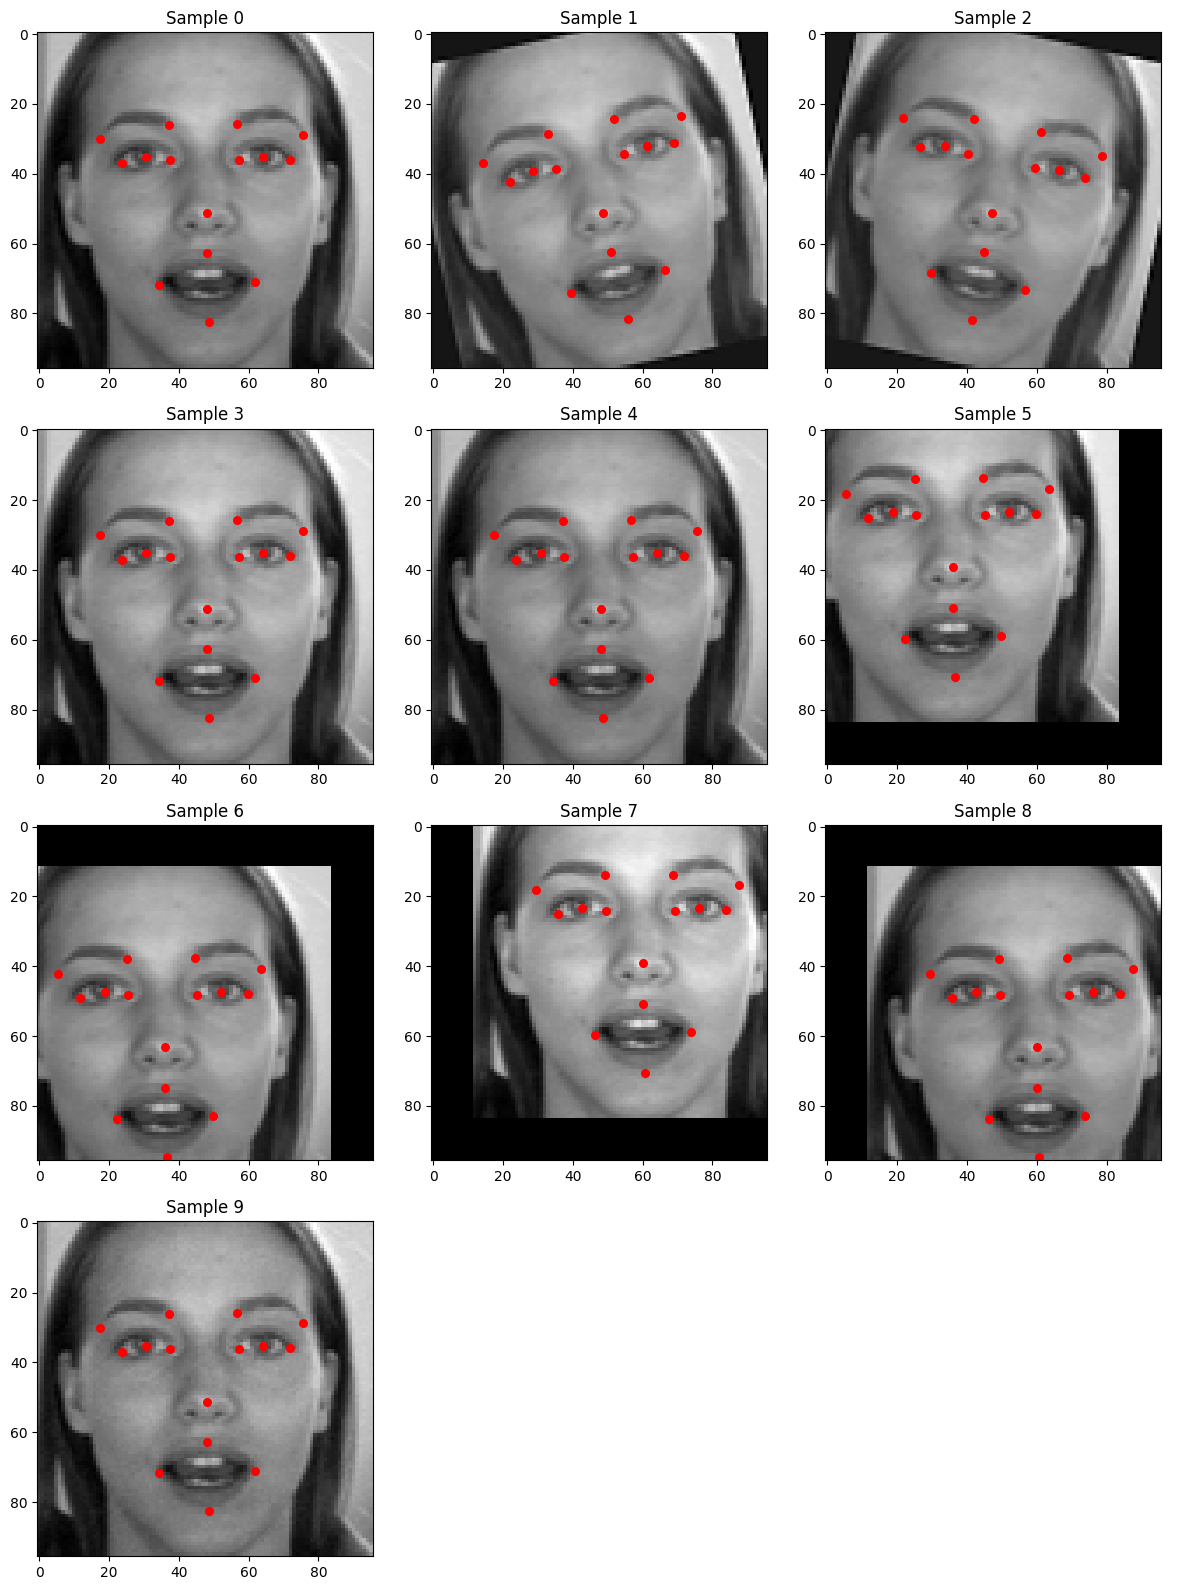

In [ ]:
train_images_aug, train_keypoints_aug = perform_augmentation(
    config,
    np.array([train_images[30]]),        # Now shape is (1, 96, 96, 1)
    np.array([train_keypoints[30]])      # Shape is (1, 30), for example
)
# Print results info
print(f"Number of augmented images: {len(train_images_aug)}")
print(f"Shape of augmented images: {train_images_aug.shape}")
print(f"Shape of augmented keypoints: {np.array(train_keypoints_aug).shape}")

# Plot using `plot_sample` with 4 images per row
n = len(train_images_aug)
cols = 3
rows = (n + cols - 1) // cols  # Ceiling division to get number of rows

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(4 * cols, 4 * rows))

# Flatten axes for easy indexing (even if there's only 1 row)
axes = axes.flatten()

for i in range(n):
    plot_sample(train_images_aug[i], train_keypoints_aug[i], axes[i], f'Sample {i}')

# Hide unused subplots if total < rows*cols
for j in range(n, rows * cols):
    axes[j].axis('off')
plt.savefig('augmented_images.png')
plt.tight_layout()
plt.show()


In [ ]:
train_images_full = load_images(train_data_full)
train_keypoints_full = load_keypoints(train_data_full)

In [ ]:
train_images_aug, train_keypoints_aug = perform_augmentation(
    config,
    train_images_full,
    train_keypoints_full
)

In [ ]:
train_images.shape

(7049, 96, 96, 1)

In [ ]:
train_images_model = np.concatenate((train_images, train_images_aug))
train_keypoints_model = np.concatenate((train_keypoints, train_keypoints_aug))

In [ ]:
train_images_model.shape

(26239, 96, 96, 1)

In [ ]:
model = Sequential()

# Input dimensions: (None, 96, 96, 1)
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 96, 96, 32)
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 48, 48, 32)
model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 48, 48, 64)
model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 24, 24, 64)
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 24, 24, 96)
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 12, 12, 96)
model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 12, 12, 128)
model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 6, 6, 128)
model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 6, 6, 256)
model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 3, 3, 256)
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 3, 3, 512)
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

# Input dimensions: (None, 3, 3, 512)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 96)     │        55,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 24, 24, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 96)     │        82,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 24, 24, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │       110,59

 Total params: 7,268,670 (27.73 MB)

 Trainable params: 7,264,318 (27.71 MB)

 Non-trainable params: 4,352 (17.00 KB)

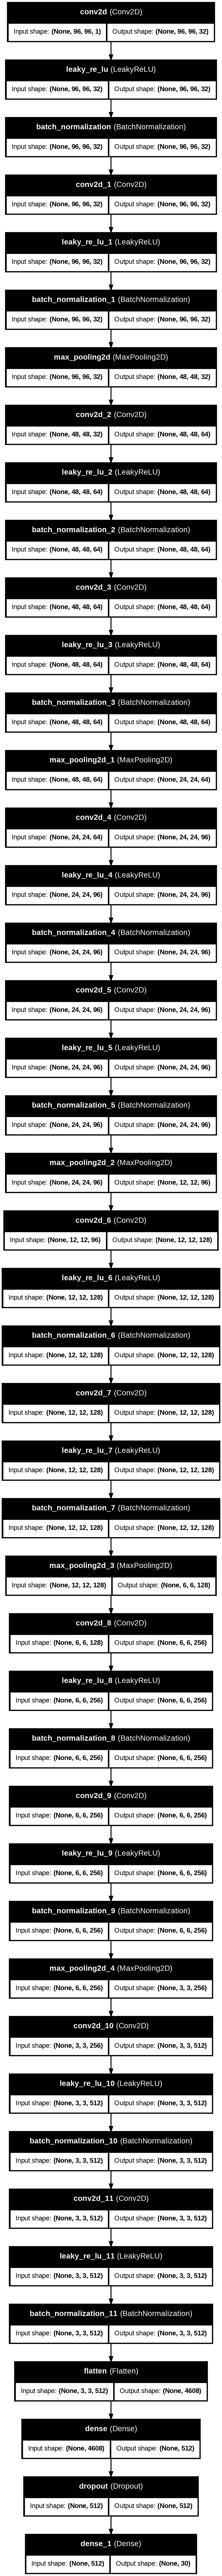

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Load model if exists, else define a new one
model_path = Path('trained_model.h5')
if model_path.exists():
    print(f"Loading model from {model_path}")
    model = load_model(model_path)
else:
    print("No pre-trained model found. Building a new one.")

No pre-trained model found. Building a new one.


In [ ]:
if not model_path.exists():
  # Callbacks
  checkpoint_cb = ModelCheckpoint(
      filepath='trained_model.h5',   # Save in HDF5 format
      monitor='mae',
      verbose=1,
      save_best_only=True,
      mode='min'
  )

  earlystop_cb = EarlyStopping(
      monitor='loss',
      patience=30,
      verbose=1,
      mode='min',
      baseline=None,
      restore_best_weights=True
  )

  reduce_LR = ReduceLROnPlateau(
      monitor='loss',
      factor=0.5,
      patience=5,
      min_lr=1e-15,
      mode='min',
      verbose=1
  )

  # Compile the model
  model.compile(
      optimizer=Adam(learning_rate=1e-3),
      loss=MeanSquaredError(),
      metrics=['mae', 'accuracy']
  )

In [ ]:
if not model_path.exists():
  # Train
  history = model.fit(
      train_images_model,
      train_keypoints_model,
      epochs=config.NUM_EPOCHS,
      batch_size=config.BATCH_SIZE,
      validation_split=0.05,
      callbacks=[checkpoint_cb, earlystop_cb, reduce_LR],
      verbose=1
  )

Epoch 1/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4315 - loss: 140.1514 - mae: 6.7676
Epoch 1: mae improved from inf to 4.20613, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 66s 113ms/step - accuracy: 0.4318 - loss: 139.9047 - mae: 6.7611 - val_accuracy: 0.3148 - val_loss: 19.5762 - val_mae: 3.3210 - learning_rate: 0.0010
Epoch 2/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6560 - loss: 14.1413 - mae: 2.8994
Epoch 2: mae improved from 4.20613 to 2.79428, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.6561 - loss: 14.1364 - mae: 2.8988 - val_accuracy: 0.7043 - val_loss: 6.1583 - val_mae: 1.8458 - learning_rate: 0.0010
Epoch 3/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7055 - loss: 9.9550 - mae: 2.4215
Epoch 3: mae improved from 2.79428 to 2.35183, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.7056 - loss: 9.9524 - mae: 2.4211 - val_accuracy: 0.7309 - val_loss: 3.9908 - val_mae: 1.4997 - learning_rate: 0.0010
Epoch 4/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7418 - loss: 8.7428 - mae: 2.2595
Epoch 4: mae improved from 2.35183 to 2.22892, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.7418 - loss: 8.7417 - mae: 2.2594 - val_accuracy: 0.7401 - val_loss: 3.8271 - val_mae: 1.4765 - learning_rate: 0.0010
Epoch 5/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7609 - loss: 8.2216 - mae: 2.1874
Epoch 5: mae improved from 2.22892 to 2.14370, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.7609 - loss: 8.2201 - mae: 2.1871 - val_accuracy: 0.7058 - val_loss: 5.8204 - val_mae: 1.9033 - learning_rate: 0.0010
Epoch 6/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7767 - loss: 7.0242 - mae: 2.0037
Epoch 6: mae improved from 2.14370 to 1.96591, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.7767 - loss: 7.0227 - mae: 2.0035 - val_accuracy: 0.7660 - val_loss: 2.8258 - val_mae: 1.3072 - learning_rate: 0.0010
Epoch 7/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7932 - loss: 6.7295 - mae: 1.9751
Epoch 7: mae improved from 1.96591 to 1.87809, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.7932 - loss: 6.7265 - mae: 1.9746 - val_accuracy: 0.7851 - val_loss: 2.6786 - val_mae: 1.2636 - learning_rate: 0.0010
Epoch 8/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8109 - loss: 5.5951 - mae: 1.7927
Epoch 8: mae improved from 1.87809 to 1.82863, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8109 - loss: 5.5964 - mae: 1.7929 - val_accuracy: 0.7584 - val_loss: 2.6120 - val_mae: 1.2162 - learning_rate: 0.0010
Epoch 9/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8120 - loss: 6.2224 - mae: 1.8975
Epoch 9: mae improved from 1.82863 to 1.78523, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8120 - loss: 6.2190 - mae: 1.8969 - val_accuracy: 0.7744 - val_loss: 2.5797 - val_mae: 1.2367 - learning_rate: 0.0010
Epoch 10/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8251 - loss: 5.0785 - mae: 1.7068
Epoch 10: mae improved from 1.78523 to 1.70280, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8251 - loss: 5.0785 - mae: 1.7067 - val_accuracy: 0.7820 - val_loss: 2.8813 - val_mae: 1.2443 - learning_rate: 0.0010
Epoch 11/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8282 - loss: 5.0424 - mae: 1.7053
Epoch 11: mae improved from 1.70280 to 1.68389, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8282 - loss: 5.0420 - mae: 1.7052 - val_accuracy: 0.8178 - val_loss: 6.1830 - val_mae: 2.0925 - learning_rate: 0.0010
Epoch 12/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8405 - loss: 4.8479 - mae: 1.6708
Epoch 12: mae improved from 1.68389 to 1.65967, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8405 - loss: 4.8477 - mae: 1.6707 - val_accuracy: 0.7721 - val_loss: 3.7066 - val_mae: 1.4053 - learning_rate: 0.0010
Epoch 13/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8411 - loss: 4.8895 - mae: 1.6685
Epoch 13: mae did not improve from 1.65967
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.8411 - loss: 4.8892 - mae: 1.6685 - val_accuracy: 0.7835 - val_loss: 2.0784 - val_mae: 1.1035 - learning_rate: 0.0010
Epoch 14/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8459 - loss: 4.5869 - mae: 1.6162
Epoch 14: mae improved from 1.65967 to 1.59880, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.8459 - loss: 4.5864 - mae: 1.6161 - val_accuracy: 0.8399 - val_loss: 1.9838 - val_mae: 1.0574 - learning_rate: 0.0010
Epoch 15/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8453 - loss: 4.4490 - mae: 1.6020
Epoch 15: mae improved from 1.59880 to 1.59835, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8453 - loss: 4.4490 - mae: 1.6020 - val_accuracy: 0.7210 - val_loss: 1.8259 - val_mae: 1.0138 - learning_rate: 0.0010
Epoch 16/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8472 - loss: 4.2976 - mae: 1.5631
Epoch 16: mae improved from 1.59835 to 1.58917, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8472 - loss: 4.2981 - mae: 1.5632 - val_accuracy: 0.8026 - val_loss: 2.2115 - val_mae: 1.1462 - learning_rate: 0.0010
Epoch 17/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8453 - loss: 4.4426 - mae: 1.5971
Epoch 17: mae improved from 1.58917 to 1.58847, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8453 - loss: 4.4424 - mae: 1.5970 - val_accuracy: 0.8369 - val_loss: 1.9602 - val_mae: 1.0547 - learning_rate: 0.0010
Epoch 18/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8511 - loss: 4.3061 - mae: 1.5679
Epoch 18: mae improved from 1.58847 to 1.58064, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.8511 - loss: 4.3063 - mae: 1.5680 - val_accuracy: 0.8293 - val_loss: 2.4670 - val_mae: 1.1746 - learning_rate: 0.0010
Epoch 19/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8551 - loss: 4.0633 - mae: 1.5264
Epoch 19: mae improved from 1.58064 to 1.54849, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.8551 - loss: 4.0639 - mae: 1.5265 - val_accuracy: 0.8521 - val_loss: 1.6597 - val_mae: 0.9914 - learning_rate: 0.0010
Epoch 20/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8537 - loss: 3.9970 - mae: 1.5166
Epoch 20: mae improved from 1.54849 to 1.53939, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8537 - loss: 3.9976 - mae: 1.5167 - val_accuracy: 0.8293 - val_loss: 1.9413 - val_mae: 1.0990 - learning_rate: 0.0010
Epoch 21/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8531 - loss: 4.3439 - mae: 1.5860
Epoch 21: mae did not improve from 1.53939
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8531 - loss: 4.3435 - mae: 1.5859 - val_accuracy: 0.8018 - val_loss: 2.7266 - val_mae: 1.3051 - learning_rate: 0.0010
Epoch 22/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8542 - loss: 4.3499 - mae: 1.5889
Epoch 22: mae did not improve from 1.53939
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8542 - loss: 4.3500 - mae: 1.5889 - val_accuracy: 0.8430 - val_loss: 1.9595 - val_mae: 1.0558 - learning_rate: 0.0010
Epoch 23/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8532 - loss: 4.0342 - mae: 1.5283
Epoch 23: mae did not improve from 1.53939
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms

390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8605 - loss: 3.8740 - mae: 1.4967 - val_accuracy: 0.8155 - val_loss: 1.6543 - val_mae: 0.9893 - learning_rate: 0.0010
Epoch 26/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8568 - loss: 3.9983 - mae: 1.5207
Epoch 26: mae did not improve from 1.51254
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.8568 - loss: 3.9987 - mae: 1.5208 - val_accuracy: 0.7896 - val_loss: 2.8355 - val_mae: 1.3423 - learning_rate: 0.0010
Epoch 27/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8590 - loss: 3.9059 - mae: 1.5113
Epoch 27: mae did not improve from 1.51254
390/390 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.8590 - loss: 3.9069 - mae: 1.5115 - val_accuracy: 0.8285 - val_loss: 1.3455 - val_mae: 0.8852 - learning_rate: 0.0010
Epoch 28/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8608 - loss: 3.7160 - mae: 1.4640
Epoch 28: mae improved from 1.51254 to 1.49778, saving model to trained_model.h5

390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8608 - loss: 3.7169 - mae: 1.4642 - val_accuracy: 0.8232 - val_loss: 1.9231 - val_mae: 1.0481 - learning_rate: 0.0010
Epoch 29/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8644 - loss: 3.7913 - mae: 1.4805
Epoch 29: mae improved from 1.49778 to 1.49477, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.8644 - loss: 3.7917 - mae: 1.4806 - val_accuracy: 0.8201 - val_loss: 1.4134 - val_mae: 0.9268 - learning_rate: 0.0010
Epoch 30/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8604 - loss: 3.8215 - mae: 1.4813
Epoch 30: mae did not improve from 1.49477
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.8604 - loss: 3.8219 - mae: 1.4814 - val_accuracy: 0.8338 - val_loss: 1.7688 - val_mae: 1.0146 - learning_rate: 0.0010
Epoch 31/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8646 - loss: 3.6978 - mae: 1.4652
Epoch 31: mae improved from 1.49477 to 1.48677, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - accuracy: 0.8646 - loss: 3.6985 - mae: 1.4653 - val_accuracy: 0.8323 - val_loss: 1.6624 - val_mae: 0.9819 - learning_rate: 0.0010
Epoch 32/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8657 - loss: 3.9176 - mae: 1.5070
Epoch 32: mae did not improve from 1.48677
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.8657 - loss: 3.9172 - mae: 1.5069 - val_accuracy: 0.7904 - val_loss: 1.8596 - val_mae: 1.0999 - learning_rate: 0.0010
Epoch 33/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8639 - loss: 3.7933 - mae: 1.4780
Epoch 33: mae improved from 1.48677 to 1.47810, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8639 - loss: 3.7933 - mae: 1.4781 - val_accuracy: 0.8384 - val_loss: 2.0977 - val_mae: 1.1684 - learning_rate: 0.0010
Epoch 34/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8594 - loss: 4.0346 - mae: 1.5334
Epoch 34: mae did not improve from 1.47810
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.8594 - loss: 4.0336 - mae: 1.5332 - val_accuracy: 0.8514 - val_loss: 2.2974 - val_mae: 1.2084 - learning_rate: 0.0010
Epoch 35/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8641 - loss: 3.8783 - mae: 1.5045
Epoch 35: mae improved from 1.47810 to 1.47115, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.8641 - loss: 3.8776 - mae: 1.5043 - val_accuracy: 0.8194 - val_loss: 1.5077 - val_mae: 0.9488 - learning_rate: 0.0010
Epoch 36/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8714 - loss: 3.8606 - mae: 1.4858
Epoch 36: mae did not improve from 1.47115
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8714 - loss: 3.8605 - mae: 1.4859 - val_accuracy: 0.8498 - val_loss: 1.9890 - val_mae: 1.1331 - learning_rate: 0.0010
Epoch 37/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8653 - loss: 3.5868 - mae: 1.4305
Epoch 37: mae improved from 1.47115 to 1.44116, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - accuracy: 0.8653 - loss: 3.5869 - mae: 1.4305 - val_accuracy: 0.8034 - val_loss: 1.6020 - val_mae: 0.9346 - learning_rate: 0.0010
Epoch 38/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8719 - loss: 3.5940 - mae: 1.4375
Epoch 38: mae improved from 1.44116 to 1.42547, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.8719 - loss: 3.5936 - mae: 1.4374 - val_accuracy: 0.8331 - val_loss: 1.7441 - val_mae: 0.9920 - learning_rate: 0.0010
Epoch 39/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8714 - loss: 3.5976 - mae: 1.4434
Epoch 39: mae did not improve from 1.42547
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8714 - loss: 3.5978 - mae: 1.4434 - val_accuracy: 0.8079 - val_loss: 2.0006 - val_mae: 1.1229 - learning_rate: 0.0010
Epoch 40/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8671 - loss: 3.4685 - mae: 1.4151
Epoch 40: mae improved from 1.42547 to 1.41927, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8671 - loss: 3.4686 - mae: 1.4151 - val_accuracy: 0.8483 - val_loss: 0.9727 - val_mae: 0.7512 - learning_rate: 0.0010
Epoch 41/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8720 - loss: 3.5840 - mae: 1.4414
Epoch 41: mae did not improve from 1.41927
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.8720 - loss: 3.5840 - mae: 1.4414 - val_accuracy: 0.8110 - val_loss: 1.5251 - val_mae: 0.9834 - learning_rate: 0.0010
Epoch 42/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8632 - loss: 3.6616 - mae: 1.4502
Epoch 42: mae did not improve from 1.41927
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8633 - loss: 3.6614 - mae: 1.4502 - val_accuracy: 0.8598 - val_loss: 0.8705 - val_mae: 0.7141 - learning_rate: 0.0010
Epoch 43/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8646 - loss: 3.5840 - mae: 1.4415
Epoch 43: mae did not improve from 1.41927
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms

390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8701 - loss: 3.5801 - mae: 1.4401 - val_accuracy: 0.7851 - val_loss: 3.6023 - val_mae: 1.5630 - learning_rate: 0.0010
Epoch 46/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8782 - loss: 3.4770 - mae: 1.4172
Epoch 46: mae did not improve from 1.41226
390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.8782 - loss: 3.4772 - mae: 1.4172 - val_accuracy: 0.8605 - val_loss: 1.3042 - val_mae: 0.8777 - learning_rate: 0.0010
Epoch 47/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8759 - loss: 3.5511 - mae: 1.4405
Epoch 47: mae did not improve from 1.41226
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8758 - loss: 3.5509 - mae: 1.4404 - val_accuracy: 0.8750 - val_loss: 1.5940 - val_mae: 1.0032 - learning_rate: 0.0010
Epoch 48/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8730 - loss: 3.4684 - mae: 1.4083
Epoch 48: mae improved from 1.41226 to 1.39366, saving model to trained_model.h5

390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.8730 - loss: 3.4679 - mae: 1.4082 - val_accuracy: 0.8750 - val_loss: 0.9309 - val_mae: 0.7441 - learning_rate: 0.0010
Epoch 49/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8761 - loss: 3.4918 - mae: 1.4139
Epoch 49: mae did not improve from 1.39366
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.8760 - loss: 3.4912 - mae: 1.4138 - val_accuracy: 0.8659 - val_loss: 1.3004 - val_mae: 0.8986 - learning_rate: 0.0010
Epoch 50/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8716 - loss: 3.3575 - mae: 1.3896
Epoch 50: mae did not improve from 1.39366
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.8716 - loss: 3.3577 - mae: 1.3896 - val_accuracy: 0.8811 - val_loss: 1.8288 - val_mae: 1.0854 - learning_rate: 0.0010
Epoch 51/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8758 - loss: 3.5871 - mae: 1.4379
Epoch 51: mae did not improve from 1.39366
390/390 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms

390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8773 - loss: 3.2506 - mae: 1.3733 - val_accuracy: 0.8636 - val_loss: 1.0823 - val_mae: 0.8040 - learning_rate: 0.0010
Epoch 53/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8786 - loss: 3.4274 - mae: 1.4138
Epoch 53: mae did not improve from 1.38739
390/390 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.8786 - loss: 3.4272 - mae: 1.4138 - val_accuracy: 0.8498 - val_loss: 1.4483 - val_mae: 0.9458 - learning_rate: 0.0010
Epoch 54/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8767 - loss: 3.6456 - mae: 1.4455
Epoch 54: mae did not improve from 1.38739
390/390 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.8767 - loss: 3.6446 - mae: 1.4453 - val_accuracy: 0.8758 - val_loss: 0.7938 - val_mae: 0.6799 - learning_rate: 0.0010
Epoch 55/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8779 - loss: 3.3795 - mae: 1.4040
Epoch 55: mae did not improve from 1.38739
390/390 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms

390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8869 - loss: 3.0012 - mae: 1.3045 - val_accuracy: 0.8788 - val_loss: 0.8148 - val_mae: 0.6971 - learning_rate: 5.0000e-04
Epoch 59/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8850 - loss: 2.9962 - mae: 1.3166
Epoch 59: mae did not improve from 1.30394
390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.8850 - loss: 2.9961 - mae: 1.3166 - val_accuracy: 0.8918 - val_loss: 0.9247 - val_mae: 0.7545 - learning_rate: 5.0000e-04
Epoch 60/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8847 - loss: 3.0237 - mae: 1.3186
Epoch 60: mae did not improve from 1.30394
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.8847 - loss: 3.0235 - mae: 1.3186 - val_accuracy: 0.8933 - val_loss: 0.8457 - val_mae: 0.7143 - learning_rate: 5.0000e-04
Epoch 61/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8869 - loss: 2.9320 - mae: 1.2978
Epoch 61: mae did not improve from 1.30394
390/390 ━━━━━━━━━━━━━━━━━

390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.8855 - loss: 2.8730 - mae: 1.2817 - val_accuracy: 0.8971 - val_loss: 0.8101 - val_mae: 0.6985 - learning_rate: 5.0000e-04
Epoch 63/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8849 - loss: 2.8910 - mae: 1.2947
Epoch 63: mae did not improve from 1.29568
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.8849 - loss: 2.8912 - mae: 1.2948 - val_accuracy: 0.8841 - val_loss: 1.2217 - val_mae: 0.8903 - learning_rate: 5.0000e-04
Epoch 64/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8875 - loss: 2.8788 - mae: 1.2918
Epoch 64: mae improved from 1.29568 to 1.29440, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.8875 - loss: 2.8790 - mae: 1.2918 - val_accuracy: 0.8910 - val_loss: 0.6980 - val_mae: 0.6369 - learning_rate: 5.0000e-04
Epoch 65/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8860 - loss: 2.8713 - mae: 1.2856
Epoch 65: mae did not improve from 1.29440
390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.8860 - loss: 2.8716 - mae: 1.2857 - val_accuracy: 0.8438 - val_loss: 1.2759 - val_mae: 0.8907 - learning_rate: 5.0000e-04
Epoch 66/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8871 - loss: 2.8499 - mae: 1.2837
Epoch 66: mae did not improve from 1.29440
390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.8871 - loss: 2.8503 - mae: 1.2838 - val_accuracy: 0.8758 - val_loss: 0.7296 - val_mae: 0.6486 - learning_rate: 5.0000e-04
Epoch 67/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8896 - loss: 2.9347 - mae: 1.3084
Epoch 67: mae improved from 1.29440 to 1.29123, saving model to trai

390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8896 - loss: 2.9346 - mae: 1.3084 - val_accuracy: 0.8880 - val_loss: 0.6276 - val_mae: 0.6003 - learning_rate: 5.0000e-04
Epoch 68/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8867 - loss: 2.8690 - mae: 1.2922
Epoch 68: mae did not improve from 1.29123
390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.8867 - loss: 2.8692 - mae: 1.2922 - val_accuracy: 0.9047 - val_loss: 0.7825 - val_mae: 0.6788 - learning_rate: 5.0000e-04
Epoch 69/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8894 - loss: 2.8350 - mae: 1.2790
Epoch 69: mae improved from 1.29123 to 1.28663, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8894 - loss: 2.8353 - mae: 1.2790 - val_accuracy: 0.8925 - val_loss: 0.7233 - val_mae: 0.6501 - learning_rate: 5.0000e-04
Epoch 70/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8925 - loss: 2.8978 - mae: 1.2959
Epoch 70: mae did not improve from 1.28663
390/390 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.8925 - loss: 2.8979 - mae: 1.2959 - val_accuracy: 0.8880 - val_loss: 0.7796 - val_mae: 0.6777 - learning_rate: 5.0000e-04
Epoch 71/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8872 - loss: 2.8548 - mae: 1.2882
Epoch 71: mae did not improve from 1.28663
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8872 - loss: 2.8549 - mae: 1.2882 - val_accuracy: 0.8933 - val_loss: 0.7907 - val_mae: 0.6849 - learning_rate: 5.0000e-04
Epoch 72/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8910 - loss: 2.9447 - mae: 1.2975
Epoch 72: mae did not improve from 1.28663
390/390 ━━━━━━━━━━━━━━━━━

390/390 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.8910 - loss: 2.9081 - mae: 1.2937 - val_accuracy: 0.8979 - val_loss: 0.9271 - val_mae: 0.7609 - learning_rate: 5.0000e-04
Epoch 74/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8953 - loss: 2.8465 - mae: 1.2840
Epoch 74: mae did not improve from 1.28514
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.8953 - loss: 2.8467 - mae: 1.2841 - val_accuracy: 0.8819 - val_loss: 0.6444 - val_mae: 0.6146 - learning_rate: 5.0000e-04
Epoch 75/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8917 - loss: 2.8613 - mae: 1.2869
Epoch 75: mae did not improve from 1.28514
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8917 - loss: 2.8616 - mae: 1.2870 - val_accuracy: 0.8994 - val_loss: 0.7008 - val_mae: 0.6496 - learning_rate: 5.0000e-04
Epoch 76/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8917 - loss: 2.8361 - mae: 1.2848
Epoch 76: mae did not improve from 1.28514
390/390 ━━━━━━━━━━━━━━━━━

390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8910 - loss: 2.7720 - mae: 1.2691 - val_accuracy: 0.8811 - val_loss: 0.6738 - val_mae: 0.6310 - learning_rate: 5.0000e-04
Epoch 78/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8876 - loss: 2.8590 - mae: 1.2858
Epoch 78: mae did not improve from 1.27809
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8877 - loss: 2.8591 - mae: 1.2858 - val_accuracy: 0.9040 - val_loss: 0.8072 - val_mae: 0.7006 - learning_rate: 5.0000e-04
Epoch 79/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8905 - loss: 2.8020 - mae: 1.2638
Epoch 79: mae improved from 1.27809 to 1.26751, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8905 - loss: 2.8020 - mae: 1.2638 - val_accuracy: 0.8742 - val_loss: 0.6377 - val_mae: 0.6046 - learning_rate: 5.0000e-04
Epoch 80/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8906 - loss: 2.9636 - mae: 1.3020
Epoch 80: mae did not improve from 1.26751
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8906 - loss: 2.9633 - mae: 1.3019 - val_accuracy: 0.8918 - val_loss: 0.6813 - val_mae: 0.6290 - learning_rate: 5.0000e-04
Epoch 81/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8943 - loss: 2.8703 - mae: 1.2929
Epoch 81: mae did not improve from 1.26751
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.8943 - loss: 2.8704 - mae: 1.2929 - val_accuracy: 0.8948 - val_loss: 0.9004 - val_mae: 0.7506 - learning_rate: 5.0000e-04
Epoch 82/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8971 - loss: 2.8452 - mae: 1.2818
Epoch 82: mae did not improve from 1.26751
390/390 ━━━━━━━━━━━━━━━━━

390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8885 - loss: 2.6807 - mae: 1.2390 - val_accuracy: 0.9009 - val_loss: 0.8011 - val_mae: 0.7068 - learning_rate: 2.5000e-04
Epoch 86/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8940 - loss: 2.6505 - mae: 1.2380
Epoch 86: mae did not improve from 1.23448
390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.8940 - loss: 2.6505 - mae: 1.2380 - val_accuracy: 0.9070 - val_loss: 0.5146 - val_mae: 0.5455 - learning_rate: 2.5000e-04
Epoch 87/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9022 - loss: 2.6776 - mae: 1.2347
Epoch 87: mae improved from 1.23448 to 1.23166, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.9022 - loss: 2.6775 - mae: 1.2347 - val_accuracy: 0.8979 - val_loss: 0.5390 - val_mae: 0.5602 - learning_rate: 2.5000e-04
Epoch 88/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8958 - loss: 2.6506 - mae: 1.2304
Epoch 88: mae improved from 1.23166 to 1.22950, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.8958 - loss: 2.6506 - mae: 1.2304 - val_accuracy: 0.8994 - val_loss: 0.6012 - val_mae: 0.6018 - learning_rate: 2.5000e-04
Epoch 89/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8977 - loss: 2.5829 - mae: 1.2248
Epoch 89: mae did not improve from 1.22950
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8977 - loss: 2.5831 - mae: 1.2248 - val_accuracy: 0.9123 - val_loss: 0.6495 - val_mae: 0.6215 - learning_rate: 2.5000e-04
Epoch 90/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8927 - loss: 2.6554 - mae: 1.2387
Epoch 90: mae did not improve from 1.22950
390/390 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.8927 - loss: 2.6555 - mae: 1.2387 - val_accuracy: 0.9009 - val_loss: 0.4810 - val_mae: 0.5252 - learning_rate: 2.5000e-04
Epoch 91/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8995 - loss: 2.5584 - mae: 1.2118
Epoch 91: mae improved from 1.22950 to 1.21697, saving model to trai

390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.8995 - loss: 2.5585 - mae: 1.2119 - val_accuracy: 0.9085 - val_loss: 0.6531 - val_mae: 0.6305 - learning_rate: 2.5000e-04
Epoch 92/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9007 - loss: 2.6437 - mae: 1.2364
Epoch 92: mae did not improve from 1.21697
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.9007 - loss: 2.6437 - mae: 1.2364 - val_accuracy: 0.9146 - val_loss: 0.5227 - val_mae: 0.5481 - learning_rate: 2.5000e-04
Epoch 93/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8986 - loss: 2.5952 - mae: 1.2231
Epoch 93: mae did not improve from 1.21697
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.8986 - loss: 2.5953 - mae: 1.2232 - val_accuracy: 0.8689 - val_loss: 0.8485 - val_mae: 0.7343 - learning_rate: 2.5000e-04
Epoch 94/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8970 - loss: 2.6022 - mae: 1.2262
Epoch 94: mae did not improve from 1.21697
390/390 ━━━━━━━━━━━━━━━━━

390/390 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.9031 - loss: 2.5143 - mae: 1.2007 - val_accuracy: 0.9040 - val_loss: 0.4365 - val_mae: 0.4987 - learning_rate: 1.2500e-04
Epoch 98/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9022 - loss: 2.4564 - mae: 1.1930
Epoch 98: mae improved from 1.20333 to 1.19966, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.9022 - loss: 2.4567 - mae: 1.1930 - val_accuracy: 0.9123 - val_loss: 0.4445 - val_mae: 0.5028 - learning_rate: 1.2500e-04
Epoch 99/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9002 - loss: 2.5291 - mae: 1.2040
Epoch 99: mae did not improve from 1.19966
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.9002 - loss: 2.5291 - mae: 1.2040 - val_accuracy: 0.9207 - val_loss: 0.5025 - val_mae: 0.5420 - learning_rate: 1.2500e-04
Epoch 100/100
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9042 - loss: 2.4840 - mae: 1.1907
Epoch 100: mae improved from 1.19966 to 1.19433, saving model to trained_model.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.9042 - loss: 2.4840 - mae: 1.1907 - val_accuracy: 0.9184 - val_loss: 0.4836 - val_mae: 0.5294 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 100.


In [ ]:
model.save('trained_model.h5')

In [ ]:
def plotAccuracy(accuracy, val_accuracy):
    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('accuracy.png')
    plt.show()

def plotLoss(loss, val_loss):
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylim(0, 10)
    plt.savefig('loss.png')
    plt.show()

def plotMAE(mae, val_mae):
    plt.plot(mae)
    plt.plot(val_mae)
    plt.title('model MAE')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('mae.png')
    plt.show()

def plotLR(lr):
    plt.plot(lr)
    plt.title('model learning rate')
    plt.ylabel('lr')
    plt.xlabel('epoch')
    plt.savefig('lr.png')
    plt.show()

Training history found. Plotting metrics...


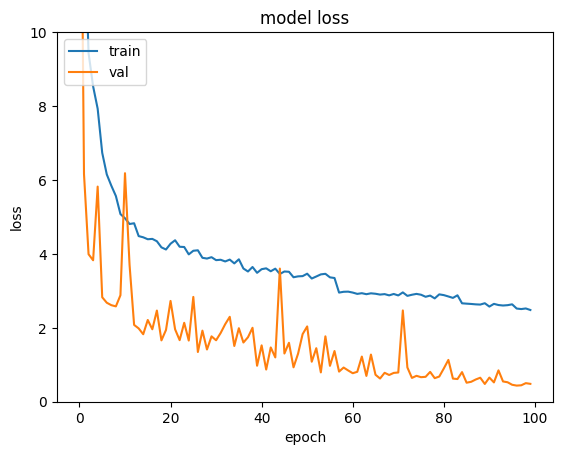

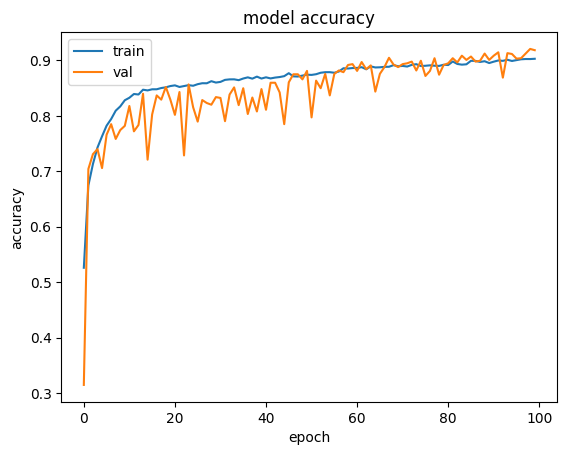

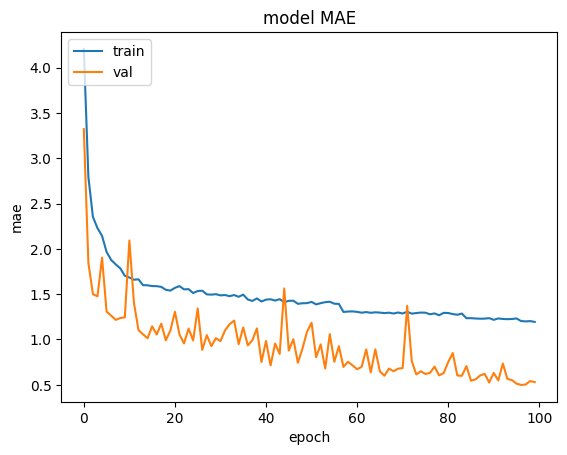

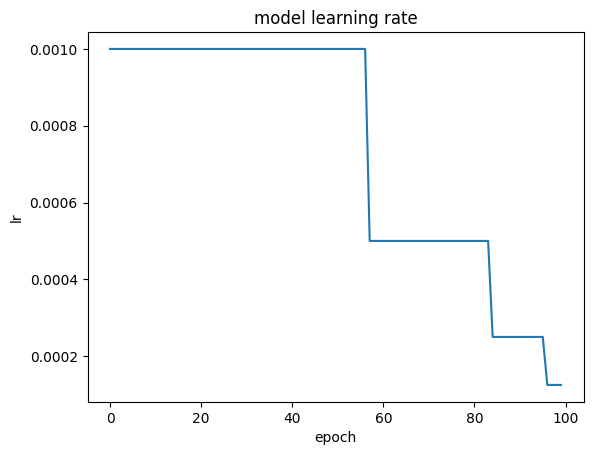

In [ ]:
if 'history' in locals():
    print("Training history found. Plotting metrics...")
    plotLoss(history.history['loss'], history.history['val_loss'])
    plotAccuracy(history.history['accuracy'], history.history['val_accuracy'])
    plotMAE(history.history['mae'], history.history['val_mae'])
    plotLR(history.history.get('learning_rate', [1e-3]*len(history.history['loss'])))
else:
    print("Model was loaded without training. No training history available for plotting.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


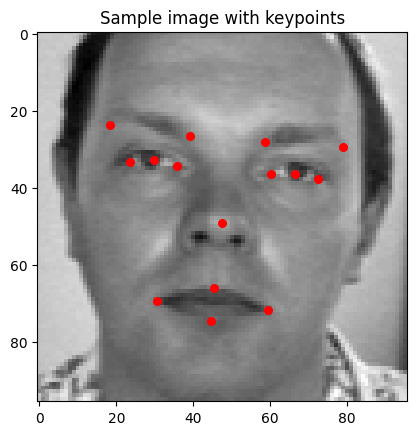

In [ ]:
idx = 15

sample_pred = model.predict(np.expand_dims(test_images[idx], axis=0))

fig, axis = plt.subplots()
plot_sample(test_images[idx], sample_pred.squeeze(), axis, "Sample image with keypoints")

In [ ]:
test_preds = model.predict(test_images)

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


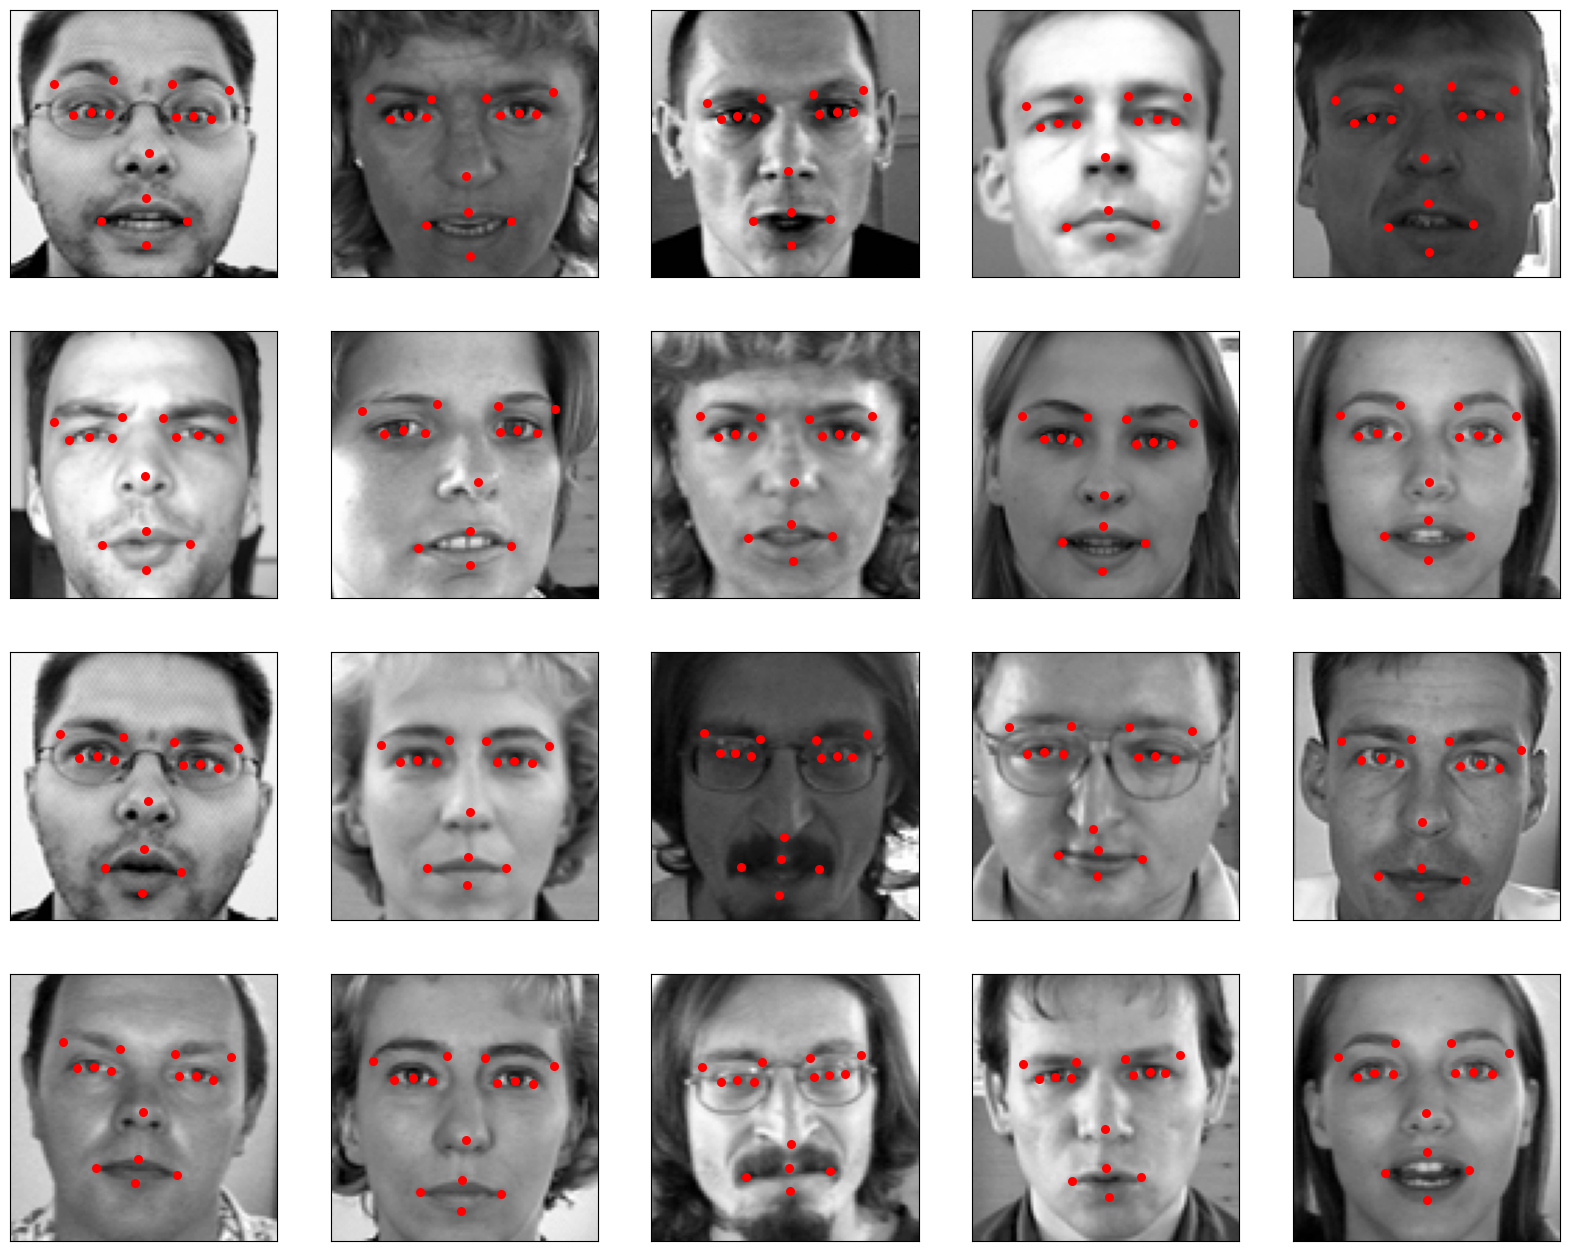

In [ ]:
fig = plt.figure(figsize=(20,16))
for i in range(20):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_sample(test_images[i], test_preds[i], axis, "")

In [ ]:
feature_names = list(lookid_data['FeatureName'])
image_ids = list(lookid_data['ImageId']-1)
row_ids = list(lookid_data['RowId'])

feature_list = []
for feature in feature_names:
    feature_list.append(feature_names.index(feature))

predictions = []
for x,y in zip(image_ids, feature_list):
    predictions.append(test_preds[x][y])

row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(predictions, name = 'Location')
locations = locations.clip(0.0,96.0)
submission_result = pd.concat([row_ids,locations],axis = 1)
submission_result.to_csv('submission.csv',index = False)

In [ ]:
tf.__version__

'2.18.0'